# Water Potability Prediction

This project aims to predict the **potability of water** based on its **physicochemical properties** using supervised machine learning models.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression


In [3]:
import kagglehub
path = kagglehub.dataset_download("adityakadiwal/water-potability")
data = pd.read_csv(f"{path}/water_potability.csv")

## Dataset Overview

- Samples: 3,276
- Features: 9 numeric physicochemical variables
- Target: Potability (0 = non-potable, 1 = potable)
- Class distribution:
  - Non-potable: ~61%
  - Potable: ~39%

Missing values:
- `ph`: 491
- `Sulfate`: 781
- `Trihalomethanes`: 162



In [ ]:
data.info()
data["Potability"].value_counts(normalize=True)


Missing values were imputed using the **median**, which is robust to outliers and allows preservation of the full dataset without introducing strong distributional bias.


In [8]:
# Replacing nulls with median 
for col in ["ph","Sulfate","Trihalomethanes"]:
    data[col] = data[col].fillna(data[col].median())

## Preprocessing

- Train/test split: 80/20 with stratification to preserve class balance
- Feature scaling applied for Logistic Regression
- Tree-based models were trained on unscaled data


In [9]:
# Splitting the data into train and test
X = data.drop(columns="Potability")
y = data["Potability"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, stratify=y, train_size=0.8
)
# Scaling data using standard scaler
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)


## Baseline

A naive classifier predicting the majority class (non-potable), but would fail to identify potable samples.  
Therefore, accuracy alone is insufficient and precision, recall, and F1-score are used for evaluation.


# Logistic Regression

In [10]:
model1 = LogisticRegression(max_iter=1000, random_state=42,class_weight="balanced")
model1.fit(X_train_scale, y_train)
y_pred_log = model1.predict(X_test_scale)
log_precision = precision_score(y_test, y_pred_log)
log_recall = recall_score(y_test, y_pred_log)
print(f"LogReg precision : {log_precision} |\nLogReg recall : {log_recall}")

LogReg precision : 0.41590214067278286 |
LogReg recall : 0.53125


Logistic Regression provides a linear baseline.  
Performance is limited due to overlapping feature distributions and class imbalance, resulting in low precision.



 # Random Forest Classifier

RF precision : 0.6513761467889908 |
RF recall : 0.27734375


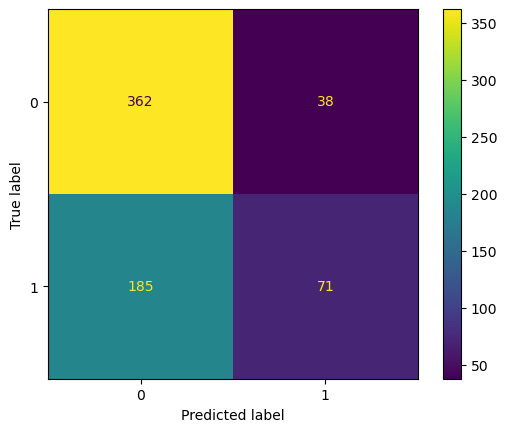

In [55]:
# Implementing random forest classifier 
model2 = RandomForestClassifier(random_state=42, class_weight="balanced")
model2.fit(X_train, y_train)
y_pred_rf = model2.predict(X_test)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_cm = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(rf_cm).plot()
print(f"RF precision : {rf_precision} |\nRF recall : {rf_recall}")

The Random Forest model captures non-linear relationships between features and improves precision compared to Logistic Regression.



# Feature Importance

In [56]:
table = pd.DataFrame({
    "feature_name" : X.columns,
    "importance" : model2.feature_importances_
})
table = table.sort_values("importance", ascending=False).reset_index(drop=True)
table

,feature_name,importance
0,ph,0.131589
1,Sulfate,0.125670
2,Chloramines,0.119226
3,Hardness,0.116898
4,Solids,0.115395
5,Conductivity,0.100869
6,Turbidity,0.097752
7,Trihalomethanes,0.096448
8,Organic_carbon,0.096153


pH, sulfate concentration, and chloramine levels were the most influential features.  
Feature importance reflects predictive usefulness, not direct causality.


# Hyperparameter Tuning

In [57]:
parameters = {
    "n_estimators": [100,250, 350], 
    "criterion" : ['gini','entropy', 'log_loss'],
    "max_depth" : [None,5,10],
    "class_weight" : ['balanced', 'balanced_subsample']
    }

gs = GridSearchCV(estimator=model2, param_grid=parameters, scoring="f1", cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
best_rf = gs.best_estimator_
y_pred = best_rf.predict(X_test)

print("precision:", precision_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


precision: 0.591715976331361
recall: 0.390625
[[331  69]
 [156 100]]


The Random Forest was optimized for F1-score using 5-fold cross-validation to balance precision and recall under class imbalance.

## Model Comparison

| Model | Precision | Recall |
|------|-----------|--------|
| Logistic Regression | ~0.42 | ~0.53 |
| Random Forest | ~0.65 | ~0.28 |
| Tuned Random Forest (F1) | ~0.59 | ~0.39 |

## Conclusion

- Random Forest outperformed Logistic Regression by modeling non-linear feature interactions.
- Performance is constrained by overlapping feature distributions.
- Metric choice depends on application context:
  - prioritize recall to minimize missed potable water
  - prioritize precision to avoid false positives
- Further improvements could include probability threshold tuning and pipeline-based preprocessing.
